Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Squared Error: 0.05501758424539039


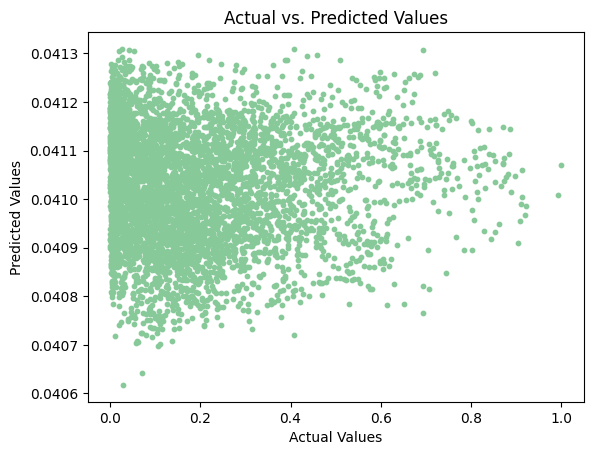

In [121]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load and preprocess the data
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/hour.csv')

# Drop unnecessary columns
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Check for missing values
df.isna().sum()

# One-hot encoding for categorical features
one_hot = pd.get_dummies(df[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']])
df = df.drop(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit'], axis=1)
df = df.join(one_hot)

# Min-max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)

# Split data into features and target
from sklearn.model_selection import train_test_split
X = df.drop(['cnt'], axis=1)
y = df['cnt']

# PyTorch model definition
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

class NeuralNet(nn.Module):
    def __init__(self, input_size, n_hidden_layers):
        super(NeuralNet, self).__init__()
        layers = [nn.Linear(input_size, 128), nn.ReLU()]
        units = 128

        # Add N hidden layers
        for _ in range(n_hidden_layers):
            units //= 2
            layers.append(nn.Linear(units * 2, units))
            layers.append(nn.ReLU())

        # Output layer for regression
        layers.append(nn.Linear(units, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, n_hidden_layers=1, epochs=10, lr=0.01):
        self.input_size = input_size
        self.n_hidden_layers = n_hidden_layers
        self.epochs = epochs
        self.lr = lr
        self.model = NeuralNet(input_size, n_hidden_layers)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.train_losses = []
        self.val_losses = []

    def fit(self, X, y):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
        X_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
        y_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)

        for epoch in range(self.epochs):
            self.model.train()
            self.optimizer.zero_grad()
            output = self.model(X_tensor)
            loss = self.criterion(output, y_tensor)
            loss.backward()
            self.optimizer.step()
            self.train_losses.append(loss.item())
            self._validate(x_val, y_val)

    def _validate(self, x_val, y_val):
        x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
        self.model.eval()
        with torch.no_grad():
            val_output = self.model(x_val_tensor)
            val_loss = self.criterion(val_output, y_val_tensor)
            self.val_losses.append(val_loss.item())

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        with torch.no_grad():
            return self.model(X_tensor).numpy()

# Perform grid search to find the best number of hidden layers
param_grid = {'n_hidden_layers': [1, 2, 3, 4, 5, 6]}
pytorch_regressor = PyTorchRegressor(input_size=X.shape[1], epochs=50)
grid = GridSearchCV(estimator=pytorch_regressor, param_grid=param_grid, cv=5)
grid_result = grid.fit(X, y)


# Retrain the model with the best number of hidden layers
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
best_model = PyTorchRegressor(input_size=X.shape[1], n_hidden_layers=grid_result.best_params_['n_hidden_layers'], epochs=50)
best_model.fit(x_train, y_train)

# Evaluate the model
predictions = best_model.predict(x_test)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.scatter(y_test, predictions, color='#88c999', s=10)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


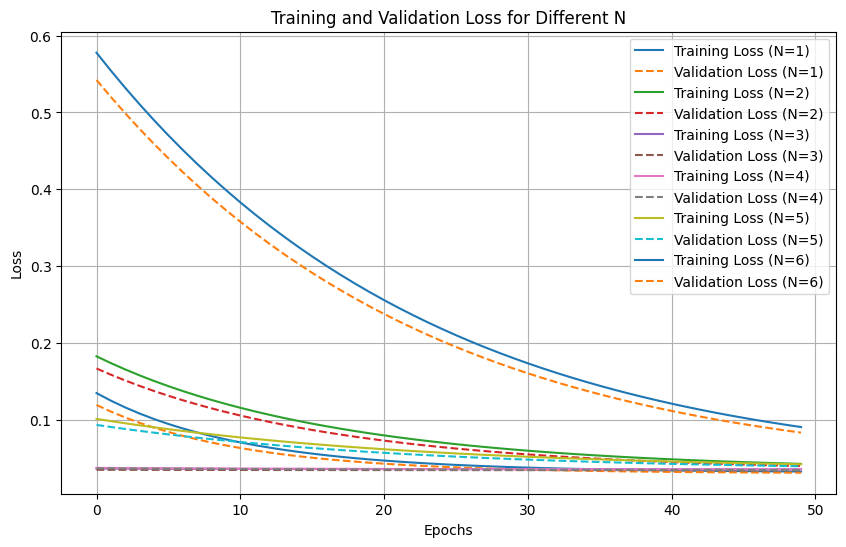

In [122]:
import matplotlib.pyplot as plt
# we need training and validation losses for each N value so we iterate over all N
N = [1,2,3,4,5,6]
losses_dict = {}
epochs = 50
for number_of_layers in N:
  model = PyTorchRegressor(input_size=input_size, n_hidden_layers=number_of_layers, epochs=epochs)
  # Store the training and validation losses for each N
  model.fit(x,y)
  losses_dict[number_of_layers] = (model.train_losses, model.val_losses)
 # print(model.train_losses)

# Plot the losses
plt.figure(figsize=(10, 6))

for n in N:
    train_losses, val_losses = losses_dict[n]
    plt.plot(train_losses, label=f'Training Loss (N={n})')
    plt.plot(val_losses, label=f'Validation Loss (N={n})', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different N')
plt.legend()
plt.grid(True)
plt.show()

**Task 8**

The best number of hidden layers is 4. 4 hidden layers is just sufficient enough to capture the complexity of the data.

**Task 9**

Mean Squared Error: 0.13393571795944453 with 3 hidden layers